# Objetivos
Objetivo 1, interpretabilidade: construir uma regressão linear simples, com poucas variáveis importantes, visando gerar insights para corretores e proprietários no quesito precificação dos imóveis. Ou seja, o foco será na interpretação dos coeficientes (ex: se aumentar a área do imóvel em uma unidade isso irá aumentar em Y o preço deste imóvel).

Objetivo 2, predição: construir um modelo com alto poder preditivo, com mais variáveis, visando um bom desempenho e com o intuito de ser usado em uma página web como a calculadora de preço. Note que, em uma situação real, um alto erro de inferência pode gerar grande insatisfação em um proprietário de imóvel, que pode ficar ofendido com o resultado. Por isso, em casos como esse, queremos ter o menor erro possível, mesmo que o modelo  seja complexo e tenha uma interpretação mais difícil

## 0. Importando as bibliotecas e o dataset

In [ ]:
# conectando com o drive
import sys
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
base_path = "/content/drive/My Drive/"

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install -U scikit-learn==0.24.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 69.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


In [ ]:
# importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Feature importance
from sklearn.inspection import permutation_importance

# Categorical encoders
from category_encoders.target_encoder import TargetEncoder

from matplotlib.dates import DateFormatter

# Stats libs
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os


#configurando a visualização da quantidade de linhas
pd.options.display.max_rows = 90
pd.options.display.max_columns = 90


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# definindo os caminhos
path_to_project  = base_path + 'reg/'
path_to_data     = path_to_project + 'data/'

In [ ]:
df= pd.read_csv(base_path + 'base.csv')
#df = pd.read_csv('base.csv')


## 1. Base de dados

O conjunto de dados descreve a venda de propriedades residenciais individuais de uma cidade americana, de 2006 a 2010. O conjunto de dados contém 2.930 observações e um grande número de features (23 nominais, 23 ordinais, 14 discretas e 20 contínuas) envolvidas na avaliação do valor dos imóveis, ou seja, são 80 variáveis explicativas.

In [ ]:
#visualizando o dataset
print(df.shape)
df.head()

(1460, 81)


,Id,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,Beco,FormaProp,PlanoProp,Servicos,ConfigLote,InclinacaoLote,Bairro,Estrada1,Estrada2,TipoHabitacao,EstiloHabitacao,Qualidade,Condicao,AnoConstrucao,AnoReforma,TipoTelhado,MaterialTelhado,Exterior1,Exterior2,TipoAlvenaria,AreaAlvenaria,QualidadeCobertura,CondicaoExterna,TipoFundacao,AlturaPorao,CondicaoPorao,ParedePorao,TipoAcabPorao1,AreaAcabPorao1,TipoAcabPorao2,AreaAcabPorao2,AreaInacabPorao,AreaPorao,Aquecimento,QualidadeAquecimento,ArCentral,InstalacaoEletrica,AreaTerreo,Area2Andar,BaixaQualiAreaAcab,AreaConstruida,BanheiroPorao,LavaboPorao,Banheiro,Lavabo,BedroomAbvGr,KitchenAbvGr,QualidadeCozinha,TotalQuartos,Funcionalidade,Lareira,QualdiadeLareira,LocalGaragem,AnoGaragem,AcabamentoGaragem,CarrosGaragem,AreaGaragem,QualidadeGaragem,CondicaoGaragem,EntradaPavimentada,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,QualidadePiscina,QualidadeCerca,Outros,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# removendo a coluna Id
df.drop(columns='Id', inplace=True)

In [ ]:
# sumário estatísticos
df.describe(percentiles = [.25, .5, .75, .95, .99]).round(2)


,ClasseImovel,Fachada,TamanhoLote,Qualidade,Condicao,AnoConstrucao,AnoReforma,AreaAlvenaria,AreaAcabPorao1,AreaAcabPorao2,AreaInacabPorao,AreaPorao,AreaTerreo,Area2Andar,BaixaQualiAreaAcab,AreaConstruida,BanheiroPorao,LavaboPorao,Banheiro,Lavabo,BedroomAbvGr,KitchenAbvGr,TotalQuartos,Lareira,AnoGaragem,CarrosGaragem,AreaGaragem,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,PrecoVenda
count,1460.0,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,56.9,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,42.3,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,20.0,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,20.0,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,50.0,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,70.0,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
95%,160.0,107.00,17401.15,8.00,8.00,2007.00,2007.00,456.00,1274.00,396.20,1468.00,1753.00,1831.25,1141.05,0.00,2466.10,1.00,1.00,2.00,1.00,4.00,1.00,10.00,2.00,2007.00,3.00,850.10,335.00,175.05,180.15,0.00,160.00,0.00,0.00,11.00,2010.00,326100.00
99%,190.0,141.00,37567.64,10.00,9.00,2009.00,2009.00,791.92,1572.41,830.38,1797.05,2155.05,2219.46,1418.92,360.00,3123.48,2.00,1.00,3.00,1.00,5.00,2.00,11.00,2.00,2009.00,3.00,1002.79,505.46,285.82,261.05,168.00,268.05,0.00,700.00,12.00,2010.00,442567.01
max,190.0,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,1418.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


In [ ]:
# informação descritiva do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ClasseImovel          1460 non-null   int64  
 1   ClasseZona            1460 non-null   object 
 2   Fachada               1201 non-null   float64
 3   TamanhoLote           1460 non-null   int64  
 4   Rua                   1460 non-null   object 
 5   Beco                  91 non-null     object 
 6   FormaProp             1460 non-null   object 
 7   PlanoProp             1460 non-null   object 
 8   Servicos              1460 non-null   object 
 9   ConfigLote            1460 non-null   object 
 10  InclinacaoLote        1460 non-null   object 
 11  Bairro                1460 non-null   object 
 12  Estrada1              1460 non-null   object 
 13  Estrada2              1460 non-null   object 
 14  TipoHabitacao         1460 non-null   object 
 15  EstiloHabitacao      

In [ ]:
# visualizando quantidade de valores nulos
df.isna().mean()

# aqui já podemos ver algumas variáveis que apresentam grande quantidade de valores nulos, como:
# Beco (+93%), QualidadePiscina (+99%), QualidadeCerca (80%) e Outros (+96%)

ClasseImovel            0.000000
ClasseZona              0.000000
Fachada                 0.177397
TamanhoLote             0.000000
Rua                     0.000000
Beco                    0.937671
FormaProp               0.000000
PlanoProp               0.000000
Servicos                0.000000
ConfigLote              0.000000
InclinacaoLote          0.000000
Bairro                  0.000000
Estrada1                0.000000
Estrada2                0.000000
TipoHabitacao           0.000000
EstiloHabitacao         0.000000
Qualidade               0.000000
Condicao                0.000000
AnoConstrucao           0.000000
AnoReforma              0.000000
TipoTelhado             0.000000
MaterialTelhado         0.000000
Exterior1               0.000000
Exterior2               0.000000
TipoAlvenaria           0.005479
AreaAlvenaria           0.005479
QualidadeCobertura      0.000000
CondicaoExterna         0.000000
TipoFundacao            0.000000
AlturaPorao             0.025342
CondicaoPo

In [ ]:
# divisão de variáveis
# 1. target
target = 'PrecoVenda'
print('target:', target)

# 2. numéricas
num_vars = df.select_dtypes(include=['int', 'float'])
num_vars_list = num_vars.columns.tolist()
num_vars_list.remove('ClasseImovel')
num_vars_list.remove('PrecoVenda')
print('variáveis numéricas:', len(num_vars_list), num_vars_list)

# 3. categóricas
cat_vars = df.select_dtypes(exclude=['int', 'float'])
cat_vars_list = cat_vars.columns.tolist()
cat_vars_list.append('ClasseImovel')
print('variáveis categóricas:', len(cat_vars_list), cat_vars_list)

target: PrecoVenda
variáveis numéricas: 35 ['Fachada', 'TamanhoLote', 'Qualidade', 'Condicao', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda']
variáveis categóricas: 44 ['ClasseZona', 'Rua', 'Beco', 'FormaProp', 'PlanoProp', 'Servicos', 'ConfigLote', 'InclinacaoLote', 'Bairro', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'EstiloHabitacao', 'TipoTelhado', 'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria', 'QualidadeCobertura', 'CondicaoExterna', 'TipoFundacao', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 

## 2. Análise Exploratória

### Distribuição target

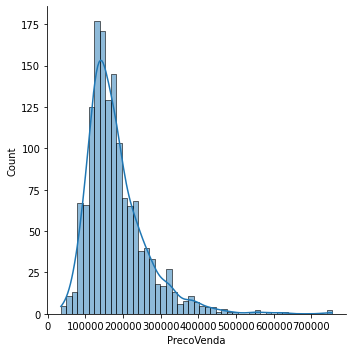

In [ ]:
# distribuição da variável dependente (PrecoVenda)
sns.displot(df['PrecoVenda'], kde=True)

### Visualizando dados faltantes

In [ ]:
dados_faltantes = df[['Fachada', 'Beco', 'TipoAlvenaria', 'AreaAlvenaria', 
                      'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 
                      'TipoAcabPorao1', 'TipoAcabPorao2', 'InstalacaoEletrica',
                      'QualdiadeLareira', 'LocalGaragem', 'AnoGaragem', 
                      'AcabamentoGaragem', 'QualidadeGaragem', 'CondicaoGaragem',
                      'CondicaoGaragem', 'QualidadePiscina', 'QualidadeCerca',
                      'Outros']]

In [ ]:
dados_faltantes.isna().mean()

Fachada               0.177397
Beco                  0.937671
TipoAlvenaria         0.005479
AreaAlvenaria         0.005479
AlturaPorao           0.025342
CondicaoPorao         0.025342
ParedePorao           0.026027
TipoAcabPorao1        0.025342
TipoAcabPorao2        0.026027
InstalacaoEletrica    0.000685
QualdiadeLareira      0.472603
LocalGaragem          0.055479
AnoGaragem            0.055479
AcabamentoGaragem     0.055479
QualidadeGaragem      0.055479
CondicaoGaragem       0.055479
CondicaoGaragem       0.055479
QualidadePiscina      0.995205
QualidadeCerca        0.807534
Outros                0.963014
dtype: float64

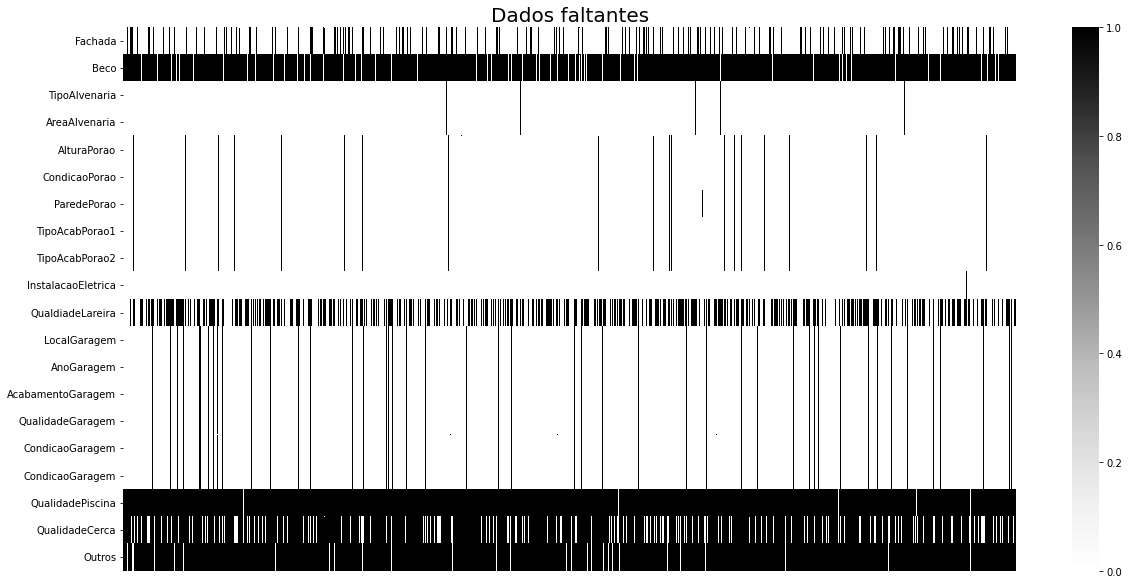

In [ ]:
# visualização dos dados faltantes
plt.figure(figsize = (20, 10))
sns.heatmap(
            dados_faltantes.isna().transpose(), 
            cmap = 'Greys',
            xticklabels = False,
            )
plt.title("Dados faltantes", fontsize = 20)
plt.show()

# 1 - faltante (preto); 0 - preenchido (branco)

### Verificando correlação entre as features

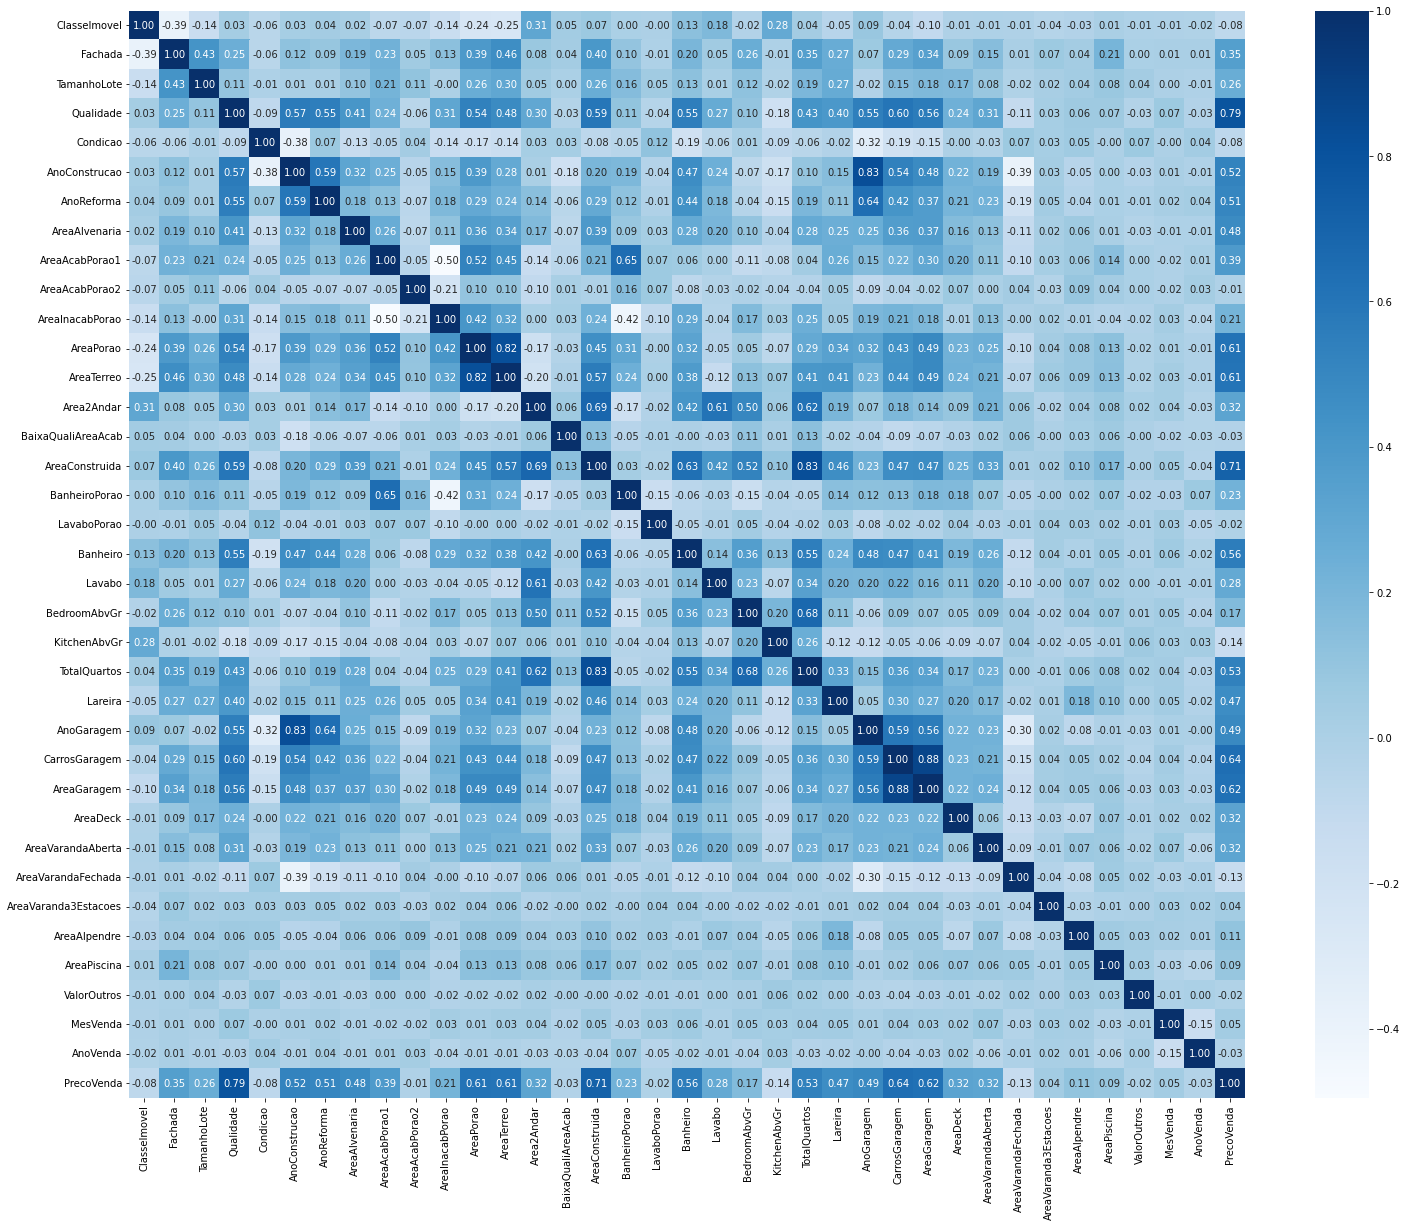

In [ ]:
# verificando correlação entre as features
plt.figure(figsize = (25,20))
sns.set_context(font_scale = 3.9)
sns.heatmap(
    df.corr(), 
  #  mask = np.triu(np.ones_like(df.corr())),
    cmap = 'Blues',
    fmt = ".2f",
    annot = True
    )
plt.show()

In [ ]:
# variáveis melhores relacionadas com o target (PrecoVenda)
melhores = df[['Qualidade', 'AnoConstrucao', 'AnoReforma', 'AreaAlvenaria', 
               'AreaPorao', 'AreaTerreo', 'AreaConstruida', 'Banheiro', 'Lareira',
               'TotalQuartos', 'AnoGaragem', 'CarrosGaragem', 'AreaGaragem',
               'PrecoVenda']]

### Visualizando correlação features com target

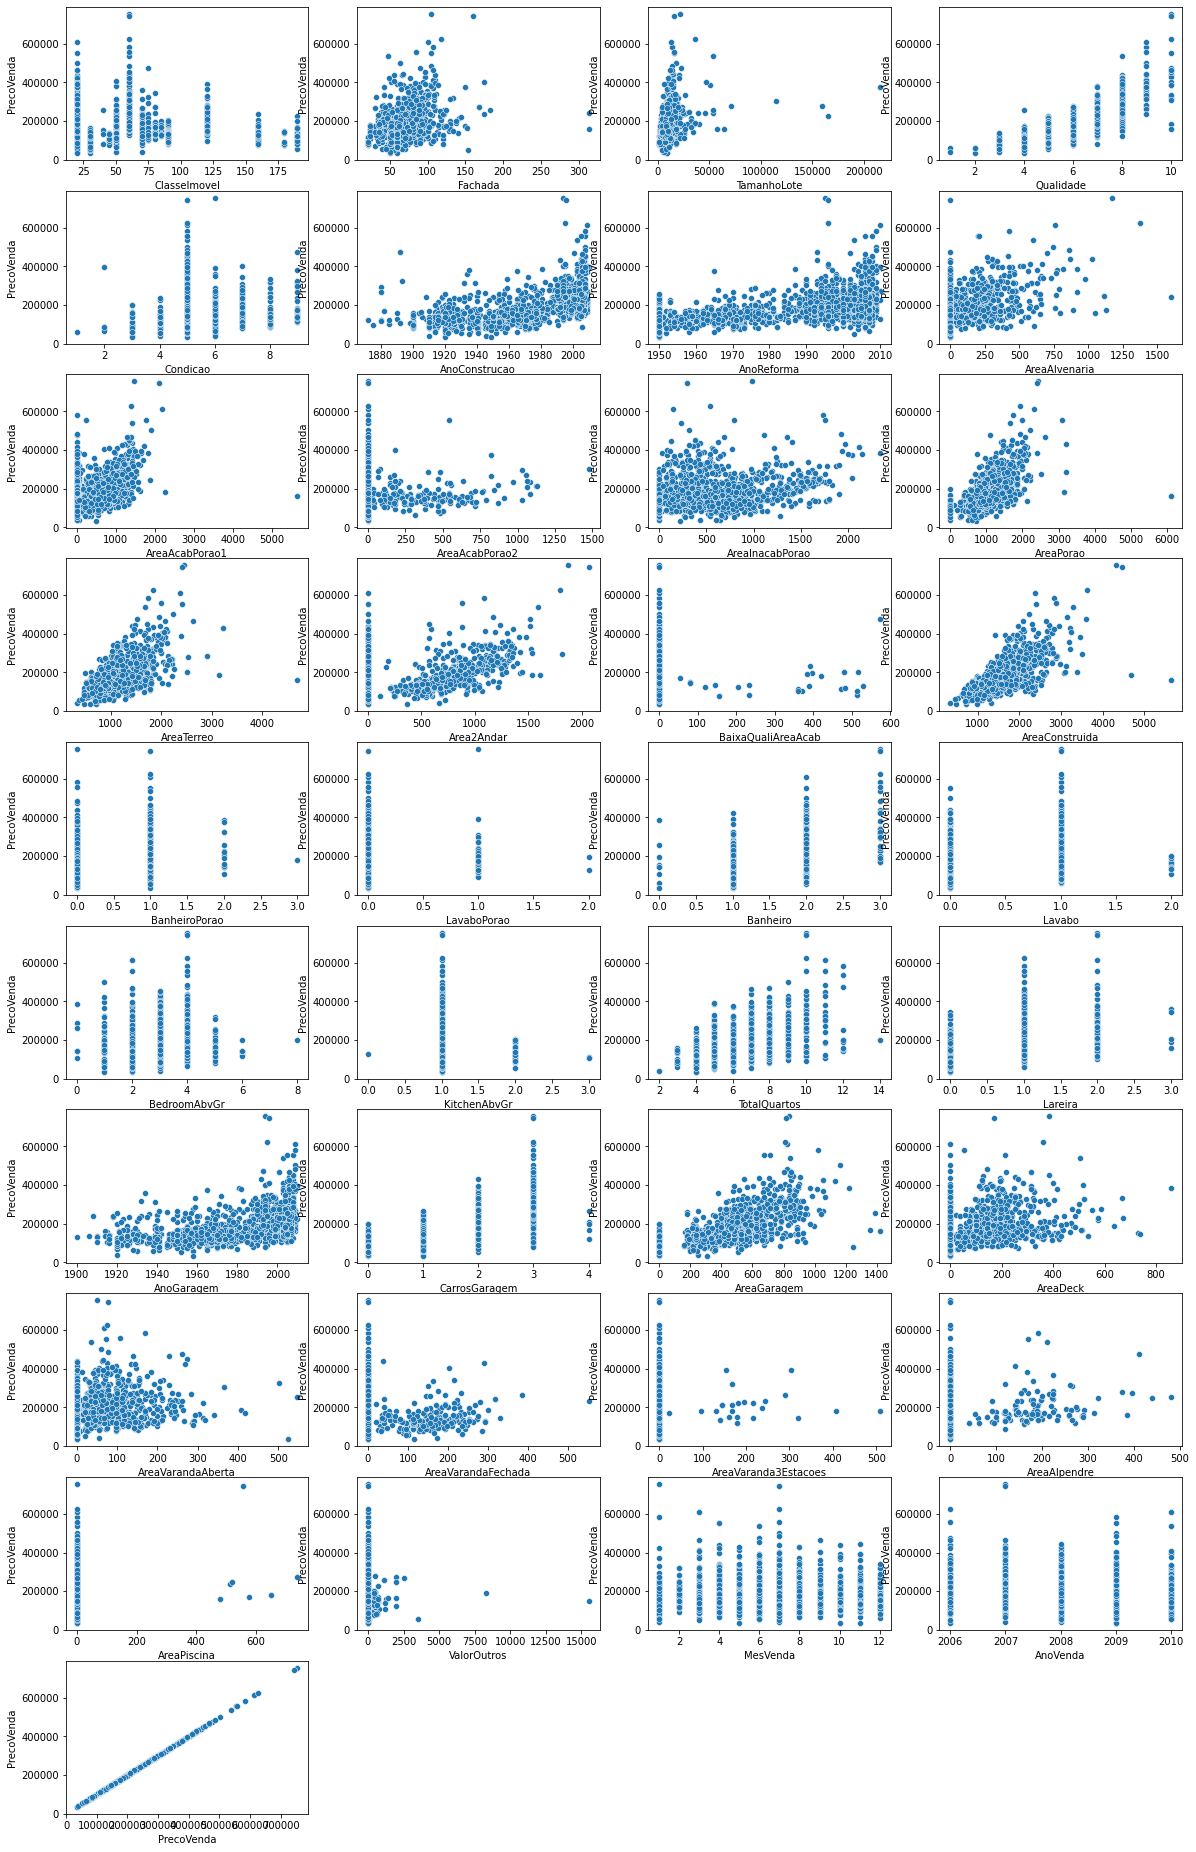

In [ ]:
plot = num_vars

plt.figure(figsize = (20,40 ))
x = 1
for d in plot:
    plt.subplot(12, 4, x)
    sns.scatterplot(data = plot, x = d, y = 'PrecoVenda', palette = 'Blues')
    x += 1
 


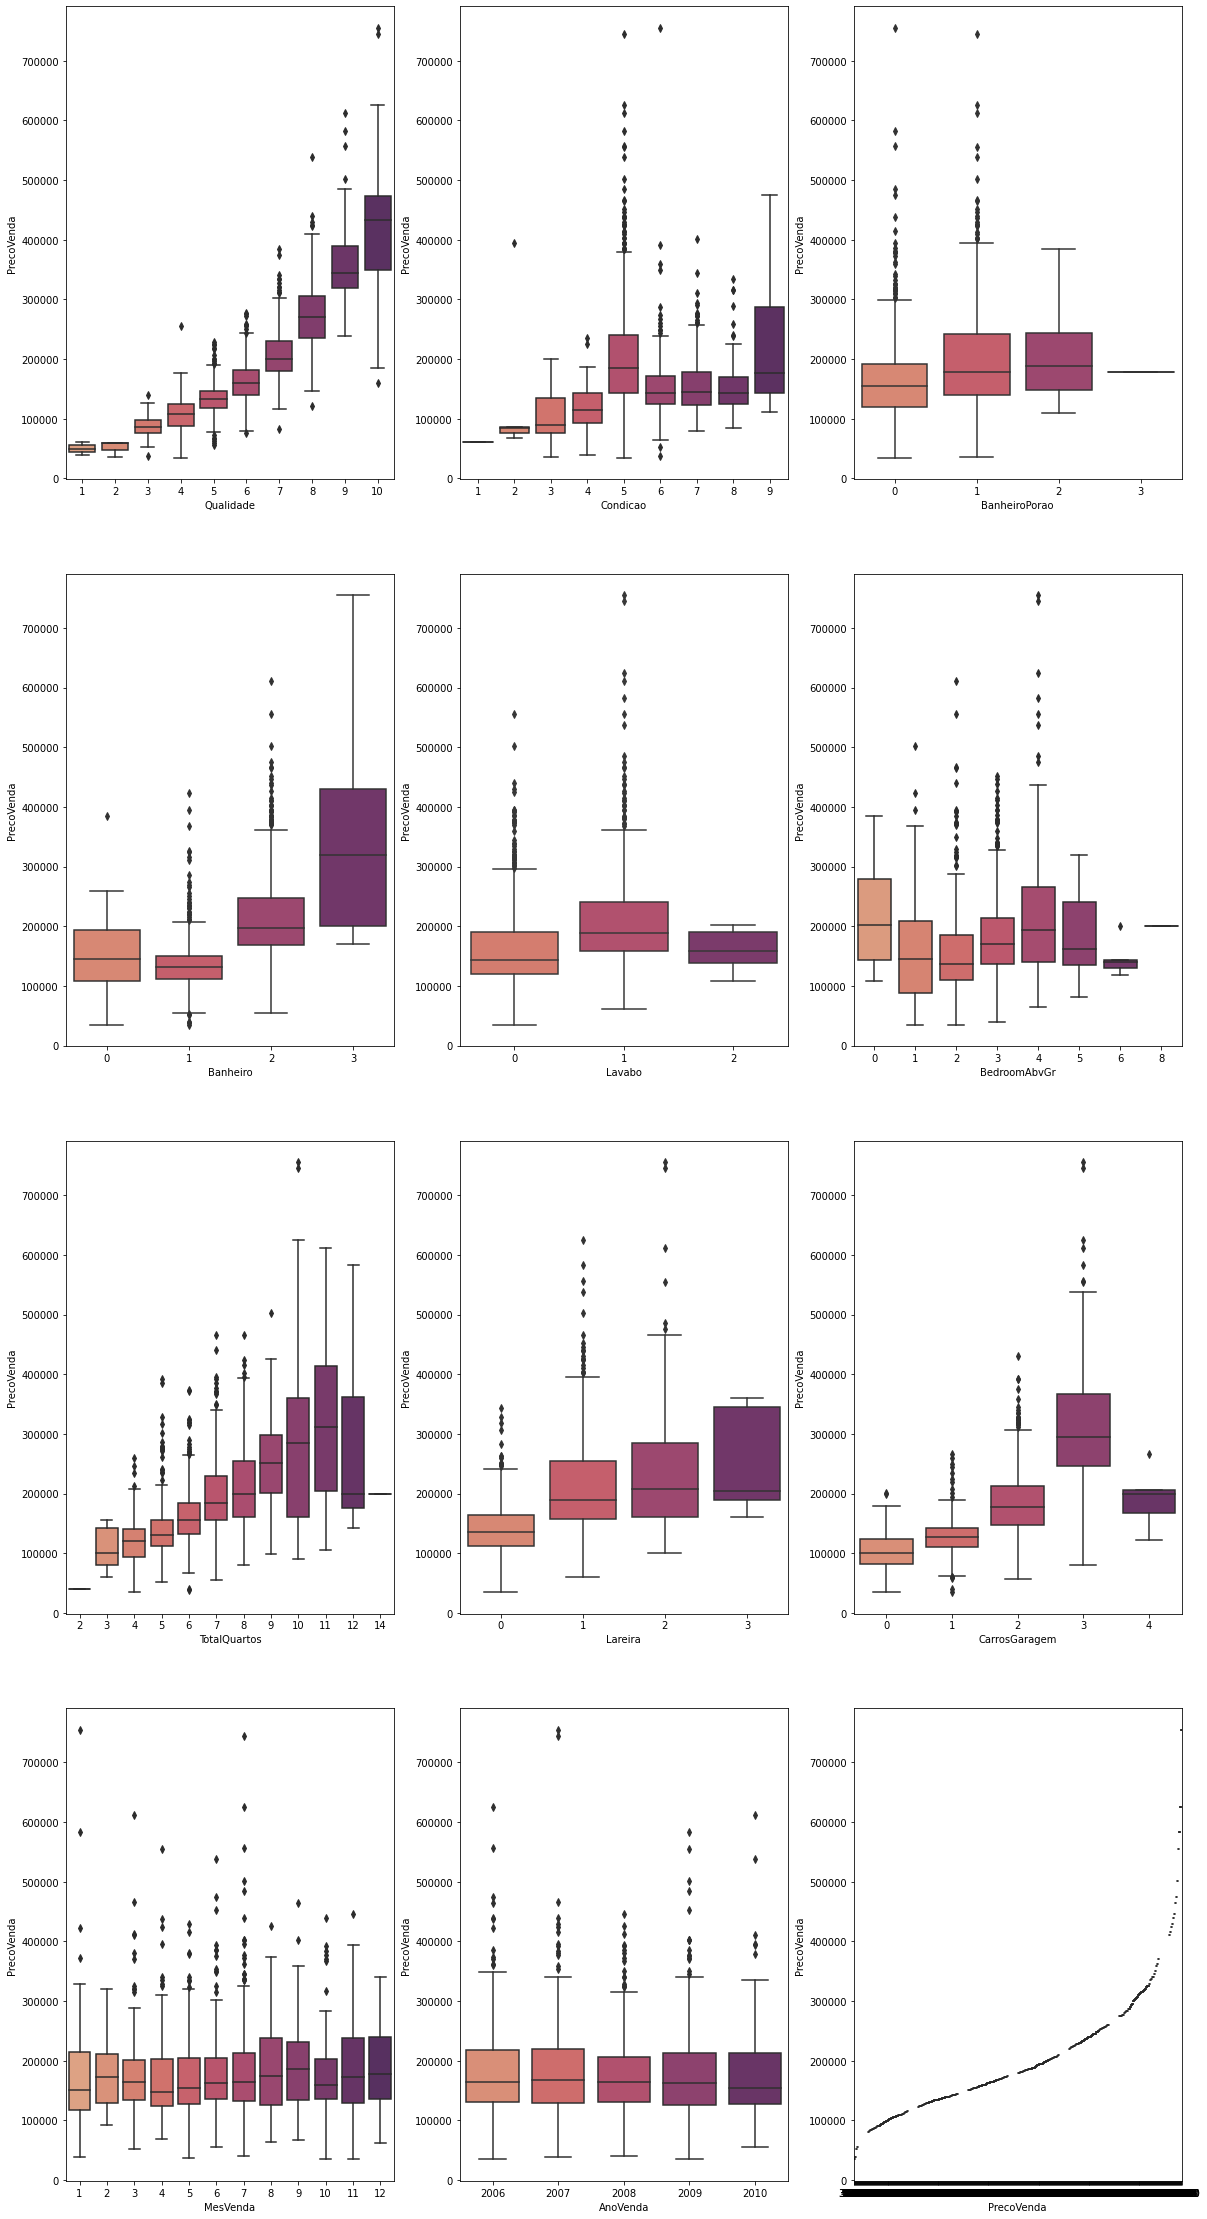

In [ ]:
#visualizando as variáveis numéricas que se comportam como categóricas
num_cat = df[['Qualidade', 'Condicao', 'BanheiroPorao', 'Banheiro', 'Lavabo', 
          'BedroomAbvGr', 'TotalQuartos', 'Lareira','CarrosGaragem', 'MesVenda',
          'AnoVenda', 'PrecoVenda']]

plt.figure(figsize = (20,40 ))
x = 1
for d in num_cat:
    plt.subplot(4, 3, x)
    sns.boxplot(data = num_cat, x = d, y = 'PrecoVenda', palette = 'flare')
    x += 1

In [ ]:
# adicionando o target nas variáveis categóricas
cat_vars = cat_vars.merge(num_vars['PrecoVenda'], how = 'left', left_index = True, right_index = True)


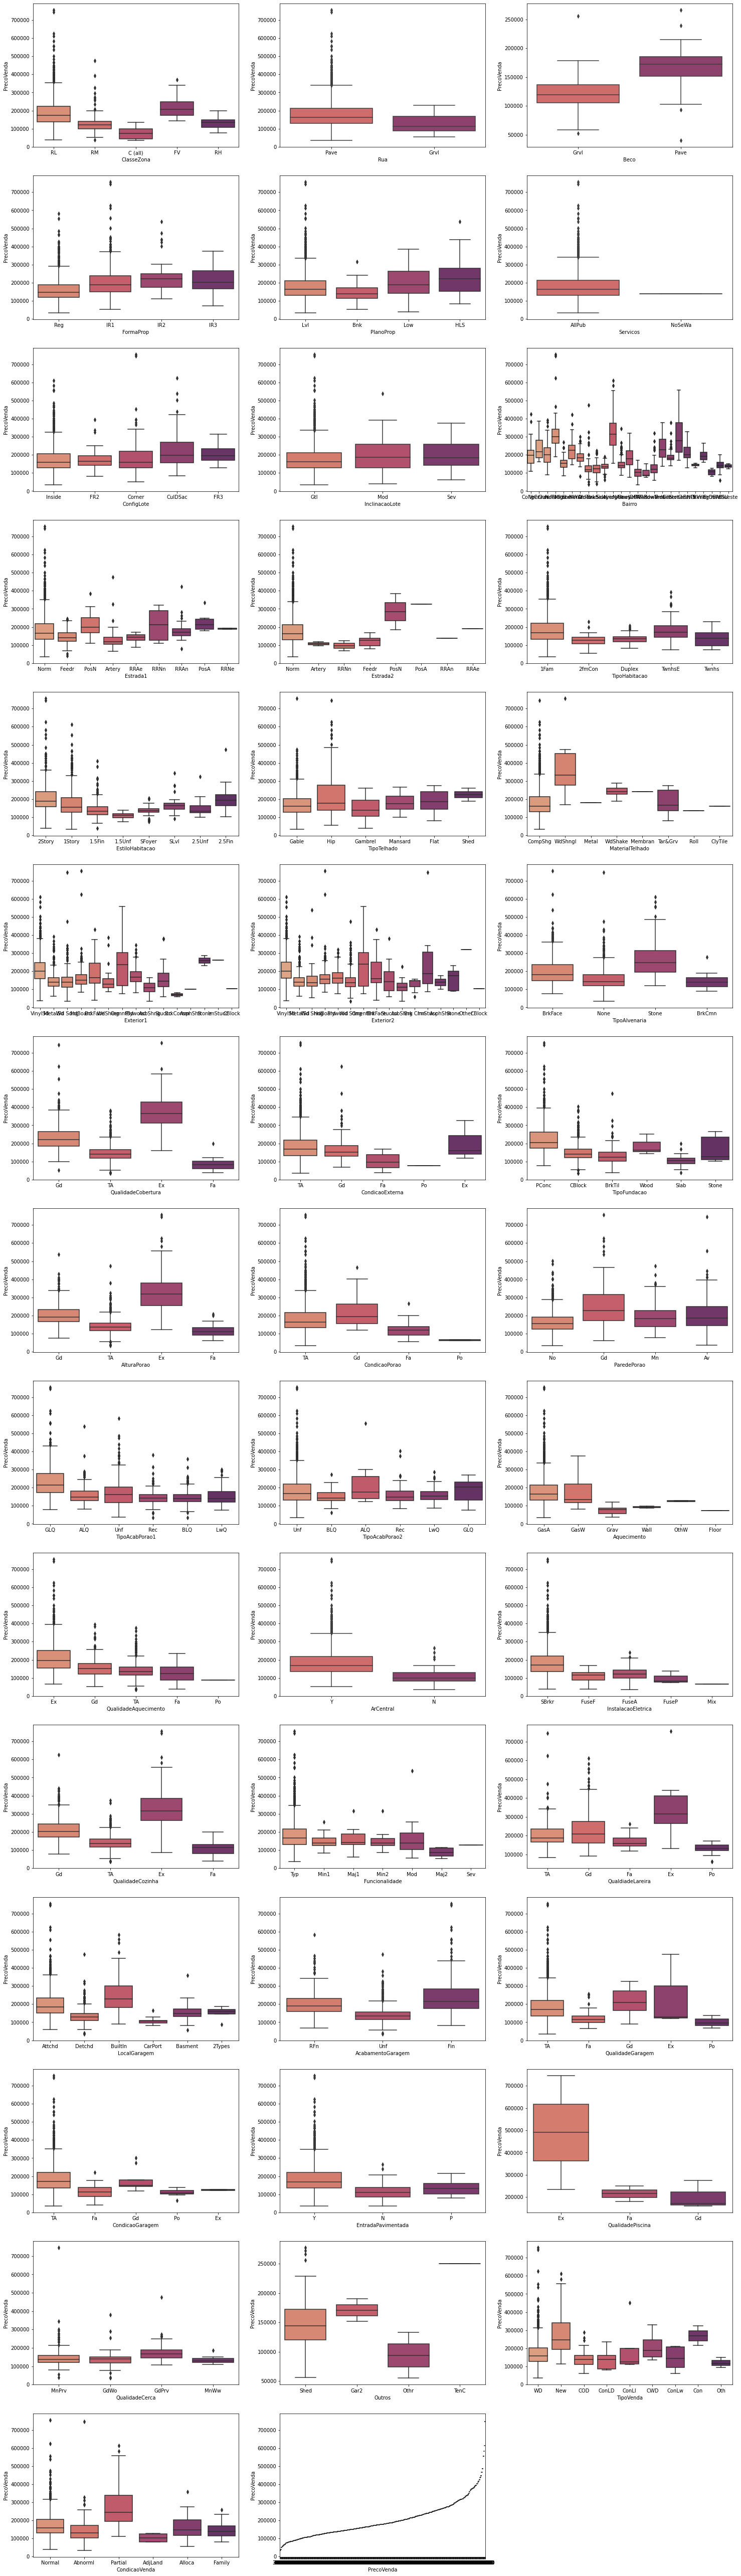

In [ ]:
# visualização das variáveis categóricas em função do target
plt.figure(figsize = (25, 100))
x = 1
for d in cat_vars:
    plt.subplot(16, 3, x)
    sns.boxplot(data = cat_vars, x = d, y = 'PrecoVenda', palette = 'flare')
    x += 1

### Divisão das features de acordo com a análise feita

In [ ]:

#Separando features de acordo com as visualizações acima

# 1. var com baixa importância

menos_import = df[['ClasseImovel', 'Fachada', 'TamanhoLote', 'Rua', 'Servicos', 
                   'ConfigLote', 'InclinacaoLote', 'Estrada1', 'Estrada2', 
                   'TipoHabitacao', 'TipoTelhado','MaterialTelhado',
                   'Exterior1', 'Exterior2','TipoAlvenaria', 'AreaAlvenaria', 
                   'ParedePorao', 'TipoAcabPorao1', 'AreaAcabPorao1',
                   'TipoAcabPorao2', 'AreaInacabPorao', 'Aquecimento', 
                   'QualidadeAquecimento', 'ArCentral', 'InstalacaoEletrica', 
                   'BaixaQualiAreaAcab', 'BanheiroPorao', 'LavaboPorao', 
                   'BedroomAbvGr', 'KitchenAbvGr', 'Funcionalidade', 'Lareira',
                   'QualdiadeLareira', 'LocalGaragem', 'AcabamentoGaragem', 
                   'QualidadeGaragem', 'CondicaoGaragem', 'EntradaPavimentada',
                   'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 
                   'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 
                   'QualidadePiscina', 'QualidadeCerca', 'Outros', 
                   'ValorOutros', 'MesVenda', 'AnoVenda', 'TipoVenda', 
                   'CondicaoVenda']]

menos_import_target = menos_import.join(df['PrecoVenda'])

# 1.1. numéricas
num_vars_low = menos_import.select_dtypes(include=['int', 'float'])
num_vars_low_list = num_vars_low.columns.tolist()
print('variáveis numéricas com baixa importância:',
      len(num_vars_low_list), num_vars_low_list)
# 1.2. categóricas
cat_vars_low = menos_import.select_dtypes(exclude=['int', 'float'])
cat_vars_low_list = cat_vars_low.columns.tolist()
print('variáveis categóricas com baixa importância:',
      len(cat_vars_low_list), cat_vars_low_list)

# 2. média importância
medio_import = df[['ClasseZona', 'Beco', 'FormaProp', 'PlanoProp', 'Bairro', 
                   'EstiloHabitacao', 'Condicao', 'AnoConstrucao', 'AnoReforma',
                   'QualidadeCobertura', 'CondicaoExterna', 'TipoFundacao',
                   'AlturaPorao', 'CondicaoPorao', 'AreaPorao', 'AreaTerreo', 
                   'Area2Andar', 'Lavabo', 'QualidadeCozinha', 'TotalQuartos', 
                   'AnoGaragem']]


# 2.1. numéricas
num_vars_med = medio_import.select_dtypes(include=['int', 'float'])
num_vars_med_list = num_vars_med.columns.tolist()
print('variáveis numéricas com média importância:',
      len(num_vars_med_list), num_vars_med_list)
# 2.2. categóricas
cat_vars_med = medio_import.select_dtypes(exclude=['int', 'float'])
cat_vars_med_list = cat_vars_med.columns.tolist()
print('variáveis categóricas com média importância:',
      len(cat_vars_med_list), cat_vars_med_list)

# 3. muita importância
muito_import = df[['Qualidade', 'AreaConstruida', 'Banheiro', 'CarrosGaragem', 
                   'AreaGaragem']]


# 3.1. numéricas
num_vars_high = muito_import.select_dtypes(include=['int', 'float'])
num_vars_high_list = num_vars_high.columns.tolist()
print('variáveis numéricas com alta importância:',
      len(num_vars_high_list), num_vars_high_list)

# 3.2. categóricas
cat_vars_high = muito_import.select_dtypes(exclude=['int', 'float'])
cat_vars_high_list = cat_vars_high.columns.tolist()
print('variáveis categóricas com alta importância:',
      len(cat_vars_high_list), cat_vars_high_list)


variáveis numéricas com baixa importância: 21 ['ClasseImovel', 'Fachada', 'TamanhoLote', 'AreaAlvenaria', 'AreaAcabPorao1', 'AreaInacabPorao', 'BaixaQualiAreaAcab', 'BanheiroPorao', 'LavaboPorao', 'BedroomAbvGr', 'KitchenAbvGr', 'Lareira', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda']
variáveis categóricas com baixa importância: 31 ['Rua', 'Servicos', 'ConfigLote', 'InclinacaoLote', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'TipoTelhado', 'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria', 'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'Aquecimento', 'QualidadeAquecimento', 'ArCentral', 'InstalacaoEletrica', 'Funcionalidade', 'QualdiadeLareira', 'LocalGaragem', 'AcabamentoGaragem', 'QualidadeGaragem', 'CondicaoGaragem', 'EntradaPavimentada', 'QualidadePiscina', 'QualidadeCerca', 'Outros', 'TipoVenda', 'CondicaoVenda']
variáveis numéricas com média importância: 9 ['Condica

---------------------------------------------------------------------
Conclusões:

-> No geral, as features que tem correlação com a área e a Garagem da casa são as mais correlacionadas com o target

-> Além dessas, temos a Qualidade da casa, quantidade de Banheiros e total de quartos

-> A qualidade da casa é uma variável que possui alguns outliers, vamos ver isso com mais calma

Variáveis que apresentam correlação positiva com o target:

Qualidade; 
AreaPorao; 
AreaConstruida; 
Banheiro; 
TotalQuartos; 
CarrosGaragem +/-;
AreaGaragem;
FormaProp;
QualidadeAquecimento;
ArCentral;


## 3. Pré-Preprocessamento

limpeza dos dados, construção de features


### Tratando dados faltantes

#### Removendo

In [ ]:
# features com muitos valores faltantes
nans = df.isna().mean()
nans[nans > 0.80]

Beco                0.937671
QualidadePiscina    0.995205
QualidadeCerca      0.807534
Outros              0.963014
dtype: float64

In [ ]:
#dropando features com muitos valores faltantes

df = df.drop(['Beco', 'QualidadePiscina', 'Outros', 'QualidadeCerca'], axis=1)

In [ ]:
df.shape

(1460, 76)

#### Preenchendo

##### Garagem

In [ ]:
nans_ = df.isna().mean()
nans_[nans_ > 0.0]

Fachada               0.177397
TipoAlvenaria         0.005479
AreaAlvenaria         0.005479
AlturaPorao           0.025342
CondicaoPorao         0.025342
ParedePorao           0.026027
TipoAcabPorao1        0.025342
TipoAcabPorao2        0.026027
InstalacaoEletrica    0.000685
QualdiadeLareira      0.472603
LocalGaragem          0.055479
AnoGaragem            0.055479
AcabamentoGaragem     0.055479
QualidadeGaragem      0.055479
CondicaoGaragem       0.055479
dtype: float64

In [ ]:
# garagem

df[['LocalGaragem', 'AnoGaragem', 'AcabamentoGaragem', 'QualidadeGaragem',
      'CondicaoGaragem', 'CarrosGaragem']].loc[df['CarrosGaragem'] == 0].head()

,LocalGaragem,AnoGaragem,AcabamentoGaragem,QualidadeGaragem,CondicaoGaragem,CarrosGaragem
39,NaN,NaN,NaN,NaN,NaN,0
48,NaN,NaN,NaN,NaN,NaN,0
78,NaN,NaN,NaN,NaN,NaN,0
88,NaN,NaN,NaN,NaN,NaN,0
89,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
df['LocalGaragem'].fillna('SemGaragem', inplace = True)
df['AnoGaragem'].fillna('SemGaragem', inplace = True)
df['AcabamentoGaragem'].fillna('SemGaragem', inplace = True)
df['QualidadeGaragem'].fillna('SemGaragem', inplace = True)
df['CondicaoGaragem'].fillna('SemGaragem', inplace = True)

In [ ]:
nans_ = df.isna().mean()
nans_[nans_ > 0.0]

Fachada               0.177397
TipoAlvenaria         0.005479
AreaAlvenaria         0.005479
AlturaPorao           0.025342
CondicaoPorao         0.025342
ParedePorao           0.026027
TipoAcabPorao1        0.025342
TipoAcabPorao2        0.026027
InstalacaoEletrica    0.000685
QualdiadeLareira      0.472603
dtype: float64

##### Porão

In [ ]:
# porão

df[['AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1',
      'TipoAcabPorao2', 'AreaPorao']].loc[df['AreaPorao'] == 0].head()

,AlturaPorao,CondicaoPorao,ParedePorao,TipoAcabPorao1,TipoAcabPorao2,AreaPorao
17,NaN,NaN,NaN,NaN,NaN,0
39,NaN,NaN,NaN,NaN,NaN,0
90,NaN,NaN,NaN,NaN,NaN,0
102,NaN,NaN,NaN,NaN,NaN,0
156,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
df['AlturaPorao'].fillna('SemPorao', inplace = True)
df['CondicaoPorao'].fillna('SemPorao', inplace = True)
df['ParedePorao'].fillna('SemPorao', inplace = True)
df['TipoAcabPorao1'].fillna('SemPorao', inplace = True)
df['TipoAcabPorao2'].fillna('SemPorao', inplace = True)

In [ ]:
nans_ = df.isna().mean()
nans_[nans_ > 0.0]

Fachada               0.177397
TipoAlvenaria         0.005479
AreaAlvenaria         0.005479
InstalacaoEletrica    0.000685
QualdiadeLareira      0.472603
dtype: float64

##### Lareira

In [ ]:
# lareira

df[['QualdiadeLareira', 'Lareira']].loc[df['Lareira'] == 0].head()

,QualdiadeLareira,Lareira
0,NaN,0
5,NaN,0
10,NaN,0
12,NaN,0
15,NaN,0


In [ ]:
df['QualdiadeLareira'].fillna('SemLareira', inplace = True)


In [ ]:
nans_ = df.isna().mean()
nans_[nans_ > 0.0]

Fachada               0.177397
TipoAlvenaria         0.005479
AreaAlvenaria         0.005479
InstalacaoEletrica    0.000685
dtype: float64

##### Alvenaria, Fachada e Instalação Elétrica

In [ ]:
## para as próximas features, iremos preencher com os valores mais frequentes
df.fillna(df['TipoAlvenaria'].value_counts().index[0], inplace=True)
df['AreaAlvenaria'].fillna(0, inplace=True)
df.fillna(df['Fachada'].value_counts().index[0], inplace=True)
df.fillna(df['InstalacaoEletrica'].value_counts().index[0], inplace=True)

In [ ]:
nans_ = df.isna().mean()
nans_[nans_ > 0.0]

Series([], dtype: float64)

### Construção de features

In [ ]:
# criação de variáveis

# 1. Área total da casa
df['AreaTotal']=df['AreaPorao'] + df['AreaTerreo'] + df['Area2Andar']

# 2. Quantidade total de banheiros
df['BanheirosTotal'] = (df['Banheiro'] + (0.5 * df['Lavabo']) +
                        df['BanheiroPorao'] + (0.5 * df['LavaboPorao']))

# 3. Área total da varanda
df['AreaVarandaTotal'] = (df['AreaVarandaAberta'] + df['AreaVaranda3Estacoes'] +
                          df['AreaVarandaFechada'] + df['AreaAlpendre'] +
                          df['AreaDeck'])

# 4. Casa reformada ou não
df['FoiReformada'] = df[['AnoConstrucao', 'AnoReforma']].apply(
    lambda x: 0 if x['AnoConstrucao'] - x['AnoReforma'] == 0 else 1, axis = 1)

# 5. Tem porão
df['TemPorao'] = 0
df.loc[df['AreaPorao']>0,'TemPorao'] = 1

# 6. Tem ar central
df['TemArCentral'] = df['ArCentral'].apply(lambda x: 1 if 'Y' in x else 0)


In [ ]:
new_vars = df[['AreaTotal', 'BanheirosTotal', 'AreaVarandaTotal', 
               'FoiReformada', 'TemPorao', 'TemArCentral']]

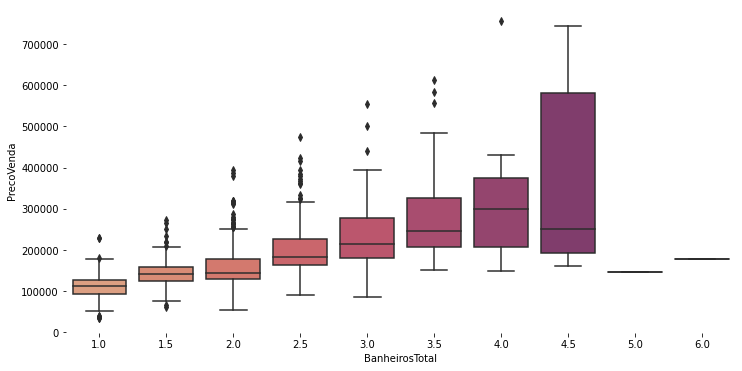

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(data = df[['BanheirosTotal', 'PrecoVenda']],
           x = 'BanheirosTotal', y = 'PrecoVenda', palette = 'flare')

sns.despine(bottom = True, left = True);

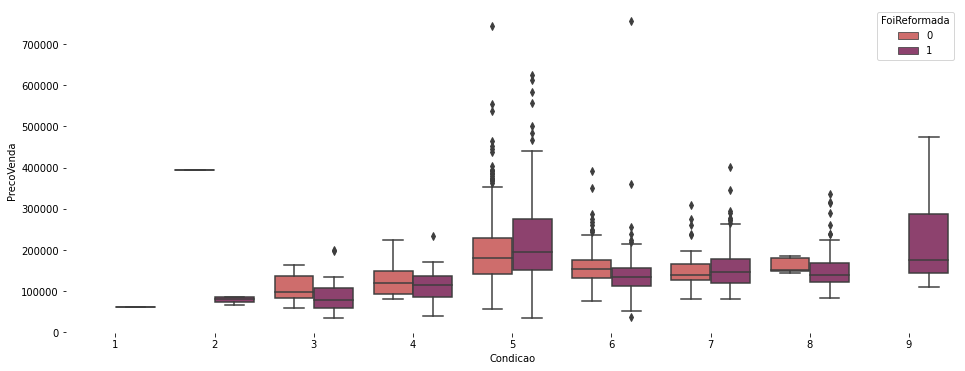

In [ ]:
plt.figure(figsize=(16, 6))

sns.boxplot(data = df[['FoiReformada', 'Condicao', 'PrecoVenda']],
           x = 'Condicao', y = 'PrecoVenda', hue = 'FoiReformada', palette = 'flare')

sns.despine(bottom = True, left = True);


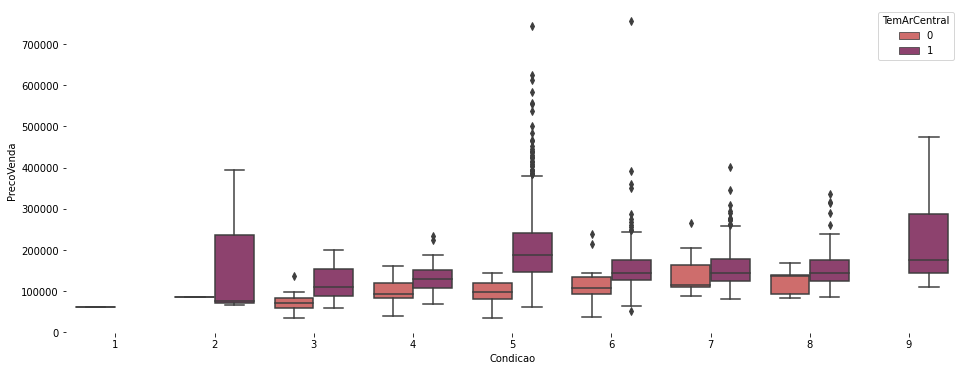

In [ ]:
plt.figure(figsize=(16, 6))

sns.boxplot(data = df[['TemArCentral', 'Condicao', 'PrecoVenda']],
           x = 'Condicao', y = 'PrecoVenda', hue = 'TemArCentral', palette = 'flare')

sns.despine(bottom = True, left = True);


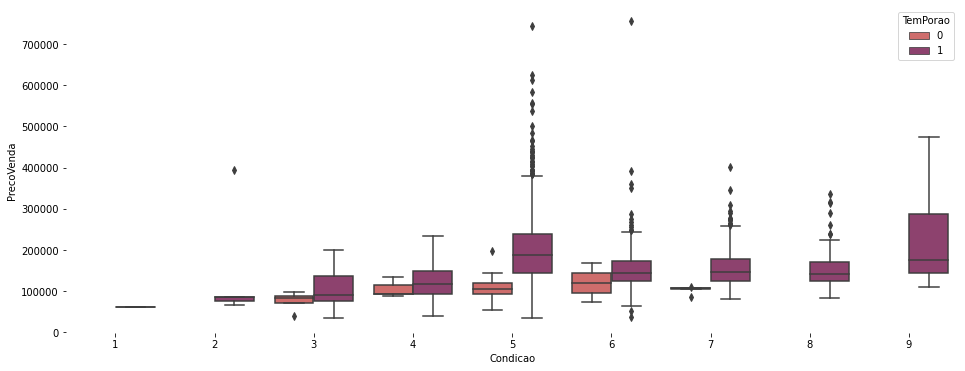

In [ ]:
plt.figure(figsize=(16, 6))

sns.boxplot(data = df[['TemPorao', 'Condicao', 'PrecoVenda']],
           x = 'Condicao', y = 'PrecoVenda', hue = 'TemPorao', palette = 'flare')

sns.despine(bottom = True, left = True);


In [ ]:
sns.set(rc={'figure.figsize':(15,10)})


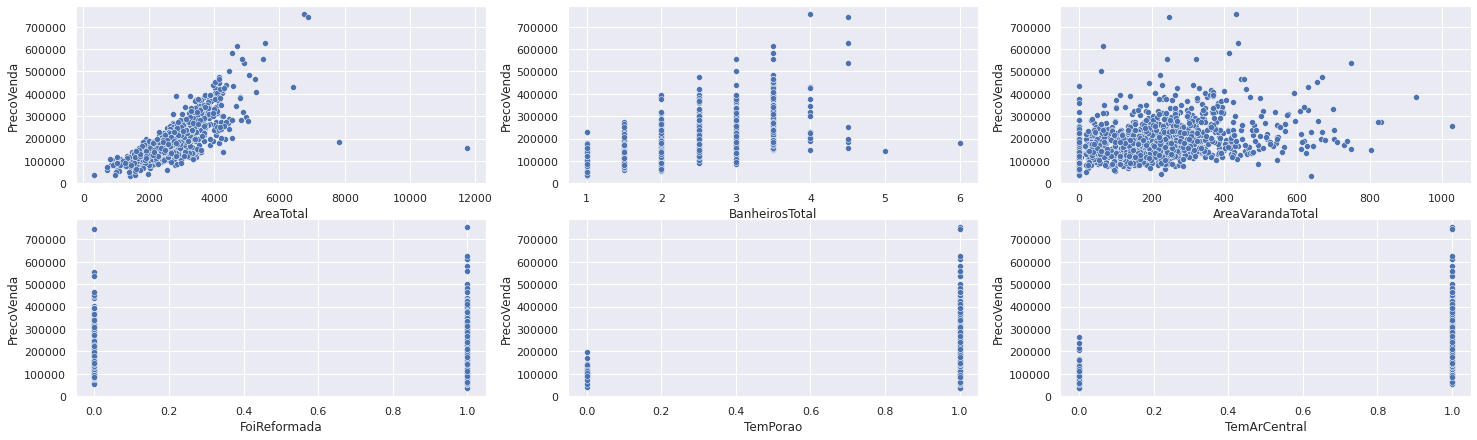

In [ ]:
plot = new_vars

plt.figure(figsize = (25,15))
x = 1
for d in plot:
    plt.subplot(4, 3, x)
    sns.scatterplot(data = plot, x = d, y = df['PrecoVenda'], palette = 'Blues')
    x += 1
 


------------------------------------------------------------------------
Das variáveis criadas, a Area Total e a BanheiroTotal foram as que mais discriminaram em relação ao target

## Objetivo 1: interpretabilidade usando uma regressão linear

- Utilize apenas exemplos onde a variável SaleCondition é igual à Normal (isso ajuda a diminuir o ruído no dado e levar a uma melhor interpretação). Crie um novo dataset aplicando esse filtro (esse dataset será usado apenas nessa etapa)

- Aplique uma transformação logarítmica na sua variável de interesse (**SalePrice**)

- Selecione 6 features para o seu modelo: onde pelo menos uma das features é uma feature construída com os valores de área do imóvel

- As outras features devem estar relacionadas ao estado de conservação da casa, suas amenidades ou instalações internas 

- Trate os valores faltantes

- Aplique as transformações nas variáveis categóricas que você julgar necessárias (One hot encoding, ordinal encoding, etc…)

- Utilize a lib statsmodel para fitar a regressão linear; use a função summary para conseguir interpretar os coeficientes

- Importante lembrar que a interpretação do coeficiente muda ao aplicar uma transformação lograritmica (ver mais aqui: http://www.cazaar.com/ta/econ113/interpreting-beta, ou aqui: https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf)

- Verifique a distribuição dos resíduos da regressão linear, e quais as implicações do resultado obtido

- Reporte o R² dessa regressão, e a sua interpretação desse resultado

- As features não podem ter alta correlação (utilizar o EDA feito previamente para encontrar as features que você julgue relevantes)

- Verifique se os pressupostos da regressão linear estão sendo atendidos (dicas: [aqui](https://lamfo-unb.github.io/2019/04/13/Diagnostico-em-Regressao/) ou [aqui](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/R/R5_Correlation-Regression/R5_Correlation-Regression4.html))

- Em um breve sumário, discorra sobre a interpretação dos coeficientes obtidos pela regressão linear (sobre interpretação ver [aqui](https://christophm.github.io/interpretable-ml-book/limo.html#interpretation))

Constraints do modelo: essa regressão linear deve ter um R² mínimo de 0.85 e conter exatamente 6 features/variáveis. Todas as features devem ter um P-value maior do que 0.95 e não podem ser colineares. Não é necessário separar esse dataset em treino e teste, já que o foco nessa etapa é na interpretação dos coeficientes de uma regressão linear.

### Condição de venda normal

In [ ]:
df_lr = df[df['CondicaoVenda'] == 'Normal'].copy()
print(df_lr.shape)
df_lr.head()

(1198, 82)


,ClasseImovel,ClasseZona,Fachada,TamanhoLote,Rua,FormaProp,PlanoProp,Servicos,ConfigLote,InclinacaoLote,Bairro,Estrada1,Estrada2,TipoHabitacao,EstiloHabitacao,Qualidade,Condicao,AnoConstrucao,AnoReforma,TipoTelhado,MaterialTelhado,Exterior1,Exterior2,TipoAlvenaria,AreaAlvenaria,QualidadeCobertura,CondicaoExterna,TipoFundacao,AlturaPorao,CondicaoPorao,ParedePorao,TipoAcabPorao1,AreaAcabPorao1,TipoAcabPorao2,AreaAcabPorao2,AreaInacabPorao,AreaPorao,Aquecimento,QualidadeAquecimento,ArCentral,InstalacaoEletrica,AreaTerreo,Area2Andar,BaixaQualiAreaAcab,AreaConstruida,BanheiroPorao,LavaboPorao,Banheiro,Lavabo,BedroomAbvGr,KitchenAbvGr,QualidadeCozinha,TotalQuartos,Funcionalidade,Lareira,QualdiadeLareira,LocalGaragem,AnoGaragem,AcabamentoGaragem,CarrosGaragem,AreaGaragem,QualidadeGaragem,CondicaoGaragem,EntradaPavimentada,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,ValorOutros,MesVenda,AnoVenda,TipoVenda,CondicaoVenda,PrecoVenda,AreaTotal,BanheirosTotal,AreaVarandaTotal,FoiReformada,TemPorao,TemArCentral
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,SemLareira,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,2566,3.5,61,0,1,1
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,2524,2.5,298,0,1,1
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,2706,3.5,42,1,1,1
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,3343,3.5,276,0,1,1
5,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,SemLareira,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000,2158,2.5,390,1,1,1


### Transformando log no target

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


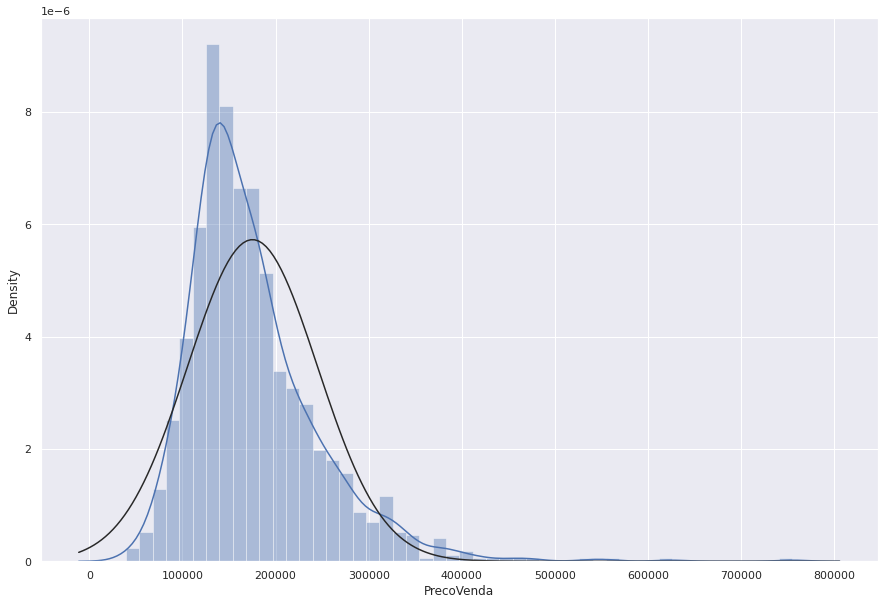

<Figure size 720x360 with 0 Axes>

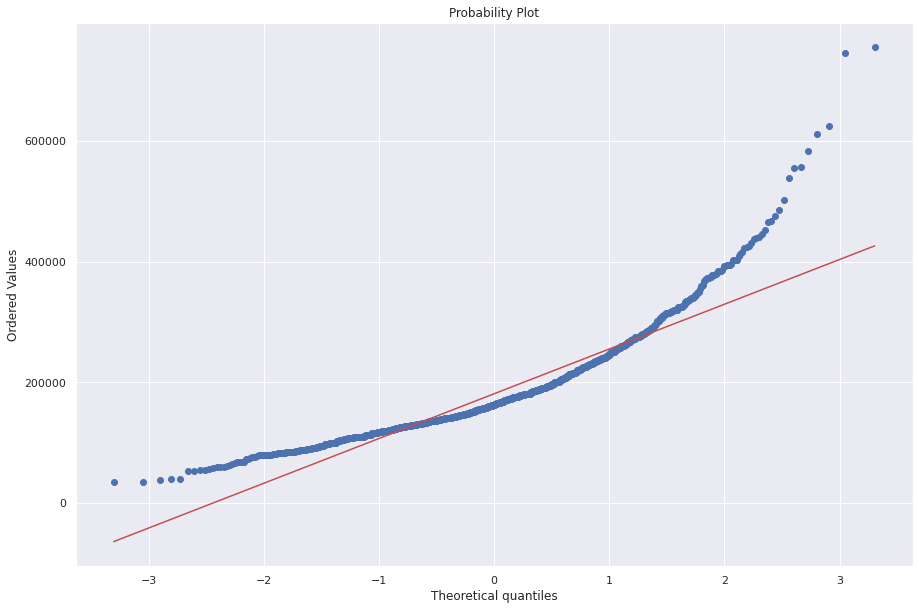

In [ ]:
sns.distplot(df_lr['PrecoVenda'], fit=norm);
plt.figure(figsize = (10,5))
fig = plt.figure()
res = stats.probplot(df['PrecoVenda'], plot=plt)

In [ ]:
df['LogPrecoVenda'] = np.log(df['PrecoVenda'].values)
df_lr['LogPrecoVenda'] = np.log(df_lr['PrecoVenda'].values)

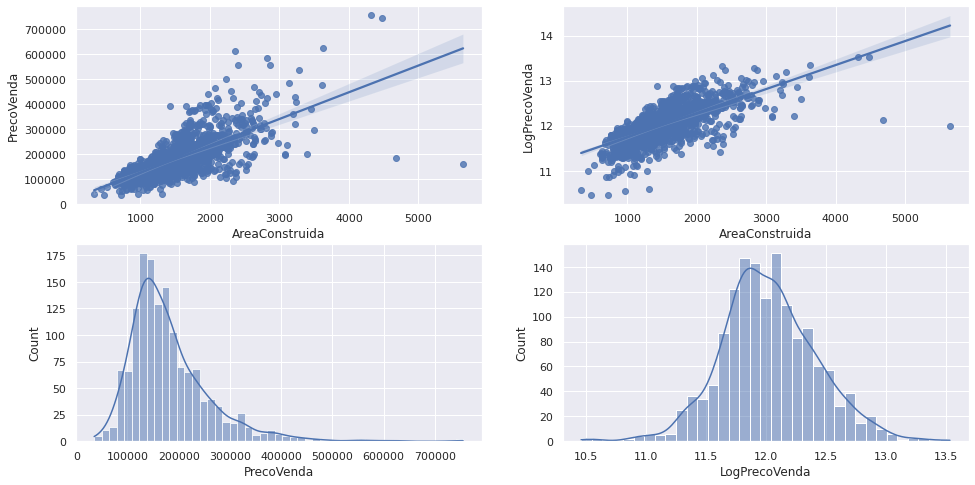

In [ ]:
fig, axs = plt.subplots(figsize=(16,8), ncols=2, nrows=2)

sns.histplot(x=df.PrecoVenda, kde=True, ax=axs[1][0])
sns.histplot(x=df.LogPrecoVenda, kde=True, ax=axs[1][1])

sns.regplot(x='AreaConstruida', y='PrecoVenda', data=df, ax=axs[0][0])
sns.regplot(x='AreaConstruida', y='LogPrecoVenda', data=df, ax=axs[0][1])

plt.show()

### Escolhendo 6 features para o modelo

In [ ]:
# melhoress variáveis
lr_vars = df_lr[['Qualidade', 'CarrosGaragem', 'AnoReforma', 'AreaVarandaTotal',
                 'AreaTotal', 'BanheirosTotal', 'PrecoVenda', 'AreaPorao', 
                 'AreaConstruida', 'TotalQuartos', 'AreaGaragem', 'FormaProp',
                 'QualidadeAquecimento', 'TemArCentral']]

# variáveis escolhidas
vars_lr = df_lr[['Qualidade', 'CarrosGaragem', 'TemArCentral', 'AreaTotal',
                 'FormaProp', 'QualidadeAquecimento']]

#AreaConstruida", "Qualidade", "CarrosGaragem", "AreaPorao", "Banheiro", "ArCentral_Y

### Tratando variáveis categóricas

In [ ]:
#'FormaProp', 'QualidadeAquecimento
dict_qualidade = {'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5}
dict_formaprop = {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}


In [ ]:
#
df_lr["FormaProp"].replace(dict_formaprop, inplace=True)
df_lr["QualidadeAquecimento"].replace(dict_qualidade, inplace=True)


In [ ]:
df_lr["QualidadeAquecimento"].head()

0    1
1    1
2    1
4    1
5    1
Name: QualidadeAquecimento, dtype: int64

### fitando a reg. linear

In [ ]:
# Montando a formula da regressao linear
formula ="LogPrecoVenda ~ " + ' + '.join(vars_lr)
print('formula: ', formula)

# Criando o modelo de regressão linear
model = smf.ols(formula = formula, data = df_lr).fit()

# Plotando o sumario do modelo
print(model.summary())

formula:  LogPrecoVenda ~ Qualidade + CarrosGaragem + TemArCentral + AreaTotal + FormaProp + QualidadeAquecimento
                            OLS Regression Results                            
Dep. Variable:          LogPrecoVenda   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     1236.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        14:22:38   Log-Likelihood:                 686.58
No. Observations:                1198   AIC:                            -1359.
Df Residuals:                    1191   BIC:                            -1324.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------

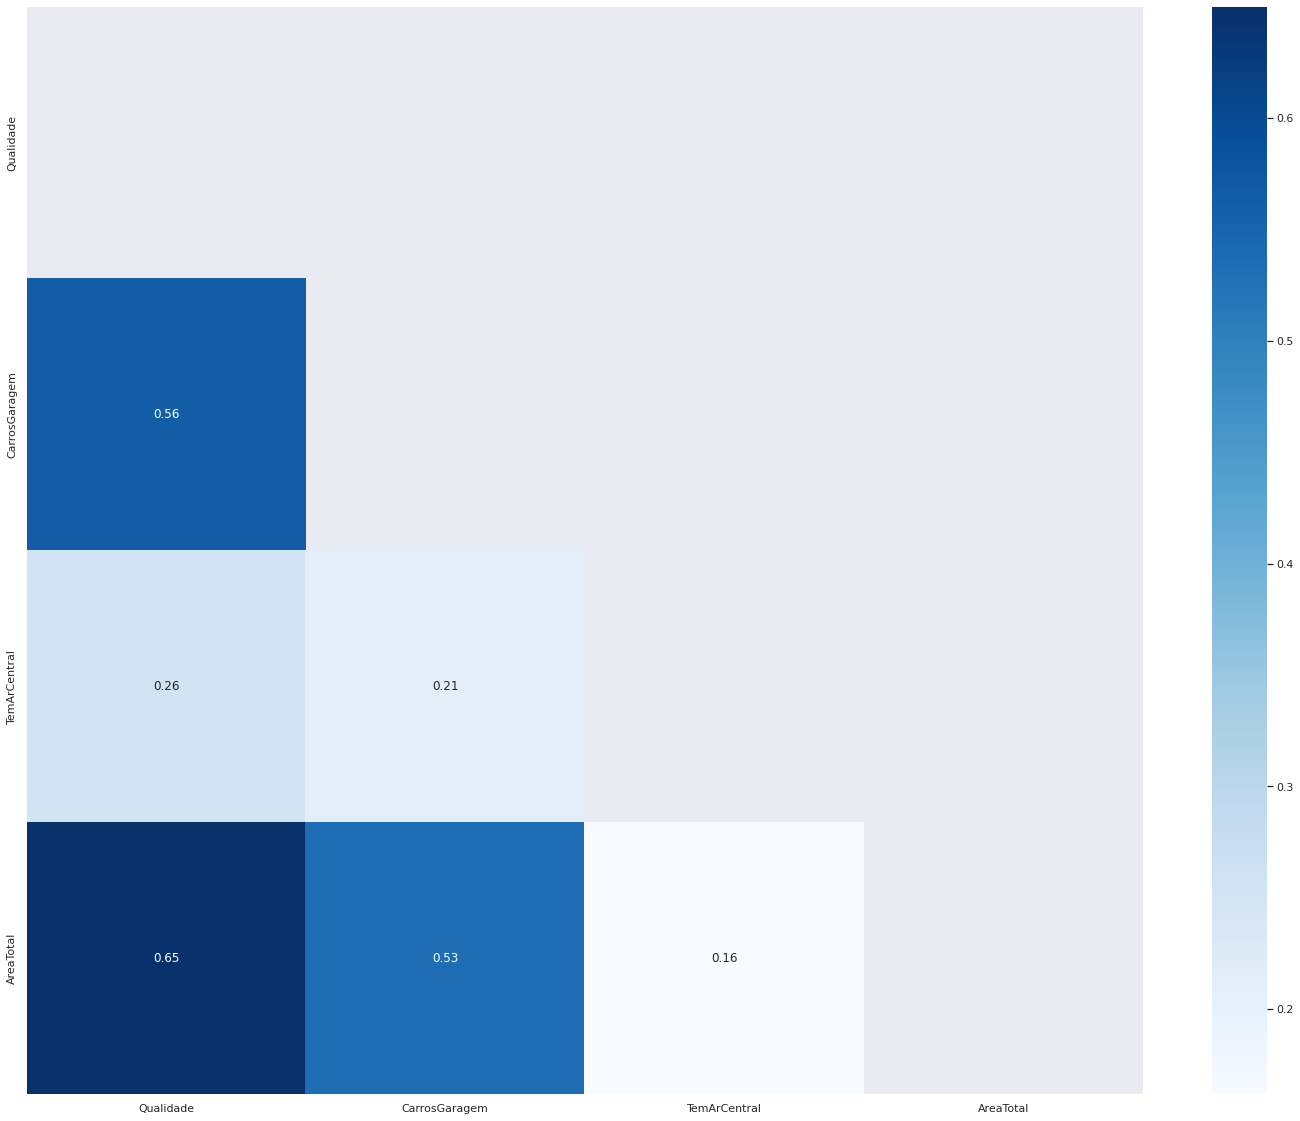

In [ ]:
# verificando correlação entre as features
plt.figure(figsize = (25,20))
sns.set_context(font_scale = 3.9)
sns.heatmap(
    vars_lr.corr(), 
    mask = np.triu(np.ones_like(vars_lr.corr())),
    cmap = 'Blues',
    fmt = ".2f",
    annot = True
    )
plt.show()

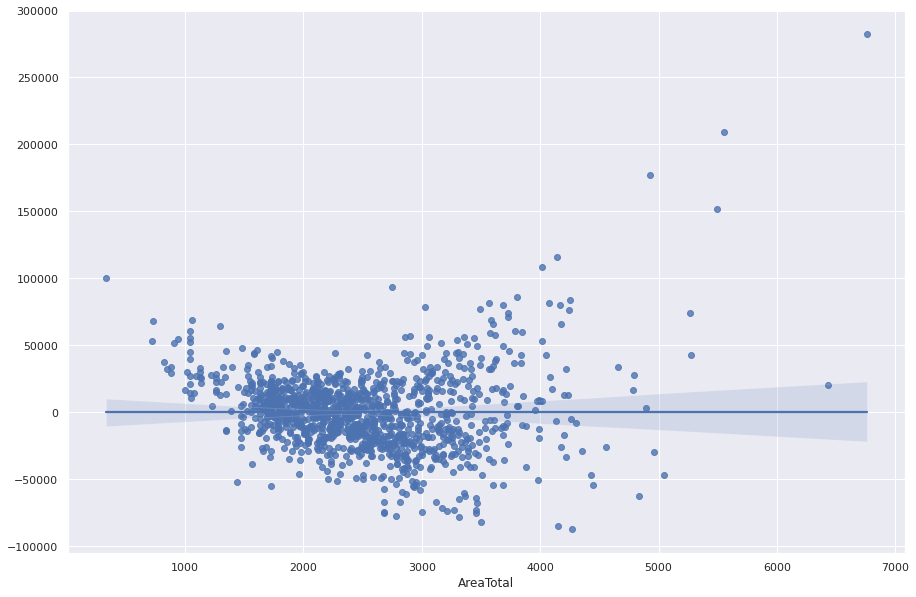

In [ ]:
sns.regplot(x=df_lr['AreaTotal'] , y=model.resid)

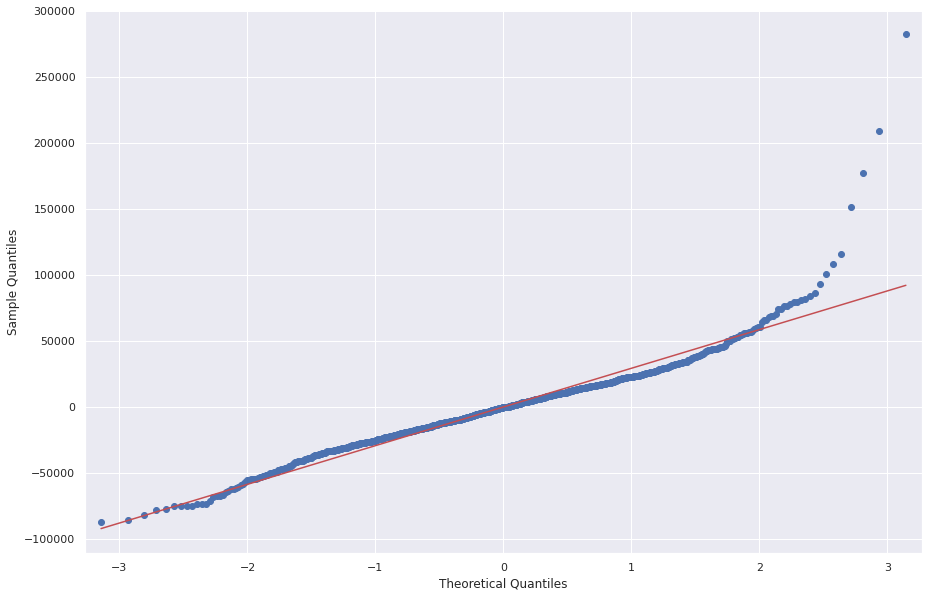

In [ ]:
sm.qqplot(model.resid, line="s");

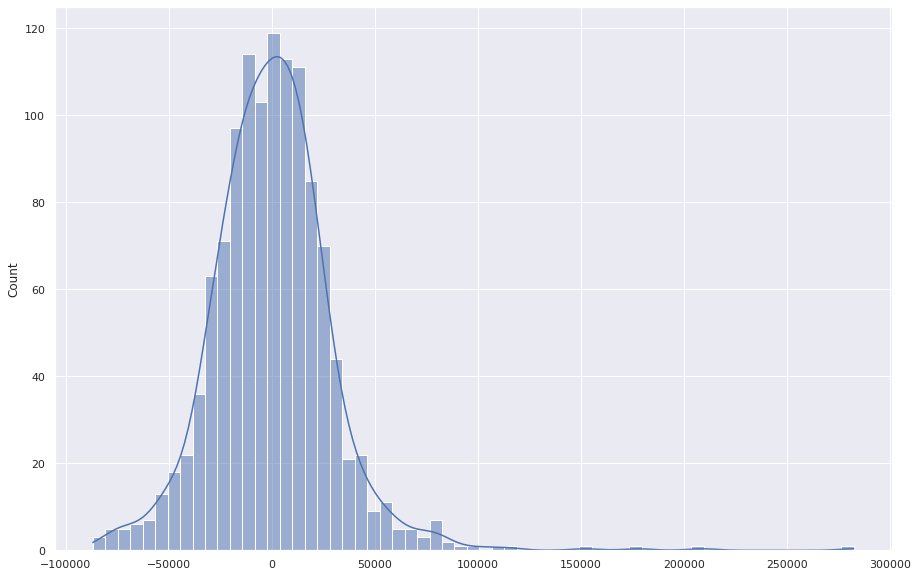

In [ ]:
sns.histplot(model.resid, kde=True)

In [ ]:
#Y ~ 0.02X1 + b2X2 + b3X3
round((np.exp(model.params[1:]) - 1)*100, 2)

Qualidade                9.90
CarrosGaragem            8.71
TemArCentral            20.03
AreaTotal                0.02
FormaProp                5.17
QualidadeAquecimento    -2.94
dtype: float64

Interpretação dos coeficientes:

Qualidade 9.90% (Aumento de 1 unidade da Qualidade aumenta em 9.90% o preço do imóvel)

CarrosGaragem 8.71% (aumento de 1 unidade de CarrosGaragem aumenta em 8.71% o preço do imóvel)

TemArCentral 20.03% (presença de ar condicionado central aumenta em 20.03% o preço do imóvel)

AreaTotal 0.02% (aumento de 1 unidade da AreaTotal aumenta em 0.02% o preço do imóvel)

FormaProp 5.17% (melhora do formato da propriedade aumenta em 5.17% o preço do imóvel)

QualidadeAquecimento -2.94 (pelo dicionário utilizado para mapear os valores categóricos, quanto menor o valor, melhor a qualidade de aquecimento, portanto: o aumento (diminuição da qualidade, de acordo com o dict) de 1 unidade de QualidadeAquecimento diminui em 2.94% o preço do imóvel)

## Objetivo 2: poder preditivo, regressão via random forest

A ideia dessa segunda parte é treinar um modelo mais robusto visando o poder preditivo e a obtenção de um modelo para uso em produção (uso real em uma aplicação web)

- Transforme o sua variável de interesse usando uma transformação logarítmica (ex: y_log=np.log(y))

- Separe seu dataset original em treino, teste, validação (ver instruções de como fazer a separação abaixo)

- Impute os valores faltantes das variáveis numéricas com a mediana e os valores faltantes das variáveis categóricas com a moda, os imputers devem ser fitados usando o dataset de treino para depois serem aplicadas nos datasets de validação e teste, isso evitará data leakage (Dica: usar os simpleimputer do sklearn) 

- Aplique as transformações nas variáveis categóricas que você julgar necessárias (One hot encoding, ordinal encoding e etc…), as transformações também devem ser fitadas usando o dataset de treino para depois serem aplicadas nos datasets de validação e teste, isso evitará data leakage (Dica: usar os transformers do sklearn) 

- Treine uma árvore inicial (modelo baseline), usando todas as features e sem mexer nos hiperparâmetros do modelo (usando n_estimators = 150), compute as métricas de avaliação no dataset de validação para você ter um baseline.

- Tente tunar o seu random forest. Teste diferentes hiperparâmetros, veja as instruções abaixo, use a documentação do sklearn para entender os hiperparâmetros que você for testar

- Compute a importância das features no dataset de validação (usar permutation_importance do sklearn), usando a importância das features remova do seu treinamento as features menos importantes para que o seu modelo tenha no máximo 40 features, verifique novamente a performance com esse número reduzido de features (isso pode melhorar a performance e a velocidade do seu modelo)

- Adicione um breve texto com sua interpretação em relação à importância das features

- Finalmente, compute as métricas de avaliação no dataset de teste para obter o proxy de performance do seu modelo em um ambiente em produção (ambiente real online).

- Adicione uma conclusão para fechar o seu case

Dica: sempre que você for avaliar o seu modelo, você deve reverter suas predições da escala log para a escala normal usando uma função exponencial (ex: y_pred = np.exp(y_pred)),

Separação dos dados em treinamento e validação: os dados devem ser separados em treino, validação e teste, na fase de exploração e modelagem você pode avaliar o modelo usando o dataset de validação para evitar overfitting, e depois, com estudo fechado aplicar as métricas de avaliação no dataset de teste (simulando a performance em exemplos nunca vistos). Para esse caso você deve separar os datasets usando a função train_test_split do sklearn, usando como random state o número 42:

- Primeiro use a função função train_test_split  para separar 70% para treino e 30% para validação e teste

- Segundo, aplique novamente essa função para quebrar esses 30% em dois datasets, sendo 50% para teste e 50% para validação. Assim obtendo 70% para treino, 15% para validação e 15% para teste

Testando diferentes hiperparâmetros do seu Random Forest: Primeiro, aumente o número de árvores (n_estimators) até que a precisão pare de melhorar. Em seguida, usando o número de árvores da primeira etapa, tente alguns valores de max_features e escolha aquele que forneça a melhor métrica. Finalmente, usando o melhor max_features, execute min_samples_leaf de 1 até 15, novamente escolhendo o melhor.

- n_estimators (10, 30, 50, 70, 100, 150, 200)

- max_features ('sqrt', 0.1 até 0.6)

- min_samples_leaf(1 até 15)

Avaliação do modelo de regressão: Para fazer a avaliação do seu modelo você deve aplicar métricas de avaliação no dataset de validação (e no final do estudo no dataset de teste), as seguintes métricas são comuns em modelos de regressão:

- R²: pense nesse score como uma medida do desempenho do nosso modelo em comparação com um modelo trivial que retorna sempre  a média para qualquer previsão solicitada. (o valor de 1.0 representa um modelo perfeito, já um valor de 0.0 representa um modelo equivalente a um modelo aleatório)

- Valor absoluto médio (MAE): que é apenas a diferença absoluta média entre os valores previstos e verdadeiros. O valor absoluto evita que desvios negativos e positivos se cancelem. 

- Em vez de tomar o valor absoluto, poderíamos elevar ao quadrado as diferenças, dando-nos o erro quadrático médio (MSE). Elevar a diferença também tem o efeito de enfatizar quaisquer previsões que estejam muito longe de seus verdadeiros valores.

- Para ignorar algumas previsões significativamente desviantes (outliers), é melhor usar o MAE no lugar MSE. Tudo depende do que você está buscando

- Como as unidades do MSE são o quadrado das unidades da variável de interesse, é útil usar a raiz do erro quadrático médio (RMSE) como métrica de avaliação

### Separação treino teste e validação

In [ ]:
X = df.drop(columns=['PrecoVenda', 'LogPrecoVenda']).copy()
y = df['PrecoVenda']

X_train, X_rem, y_train, y_rem = train_test_split(X,y, test_size=0.30, random_state = 13)

test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state = 13)

print('X Train shape', X_train.shape), print('y train shape', y_train.shape)
print('X Val shape', X_val.shape), print('y val shape', y_val.shape)
print('X Test shape', X_test.shape), print('y test shape',y_test.shape) 

X Train shape (1022, 81)
y train shape (1022,)
X Val shape (219, 81)
y val shape (219,)
X Test shape (219, 81)
y test shape (219,)


(None, None)

### pré processamento dos datasets de treino, teste e validação

In [ ]:
# Features numericas
num_features = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_features.remove('ClasseImovel')
num_features.remove('LogPrecoVenda')
num_features.remove('PrecoVenda')
print(f'numerical features({len(num_features)}): {num_features}')

# Features categoricas
cat_features = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_features.append('ClasseImovel')
df[cat_features] = df[cat_features].astype("category")
print(f'categorical features({len(cat_features)}): {cat_features}')

# features_to_remove = ['AnoVenda', 'LogPrecoVenda', 'PrecoVenda']

numerical features(38): ['TamanhoLote', 'Qualidade', 'Condicao', 'AnoConstrucao', 'AnoReforma', 'AreaAcabPorao1', 'AreaAcabPorao2', 'AreaInacabPorao', 'AreaPorao', 'AreaTerreo', 'Area2Andar', 'BaixaQualiAreaAcab', 'AreaConstruida', 'BanheiroPorao', 'LavaboPorao', 'Banheiro', 'Lavabo', 'BedroomAbvGr', 'KitchenAbvGr', 'TotalQuartos', 'Lareira', 'CarrosGaragem', 'AreaGaragem', 'AreaDeck', 'AreaVarandaAberta', 'AreaVarandaFechada', 'AreaVaranda3Estacoes', 'AreaAlpendre', 'AreaPiscina', 'ValorOutros', 'MesVenda', 'AnoVenda', 'AreaTotal', 'BanheirosTotal', 'AreaVarandaTotal', 'FoiReformada', 'TemPorao', 'TemArCentral']
categorical features(43): ['ClasseZona', 'Fachada', 'Rua', 'FormaProp', 'PlanoProp', 'Servicos', 'ConfigLote', 'InclinacaoLote', 'Bairro', 'Estrada1', 'Estrada2', 'TipoHabitacao', 'EstiloHabitacao', 'TipoTelhado', 'MaterialTelhado', 'Exterior1', 'Exterior2', 'TipoAlvenaria', 'AreaAlvenaria', 'QualidadeCobertura', 'CondicaoExterna', 'TipoFundacao', 'AlturaPorao', 'CondicaoPorao

In [ ]:
def random_forest_preprocessing(X_train, X_val, X_test, y_train):

  # Categoricals pre-processing (missing imputer)
  cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  # Categoricals pre-processing (missing imputer)
  cat_imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
  X_train[cat_features] = cat_imputer.fit_transform(X_train[cat_features])
  X_val[cat_features] = cat_imputer.transform(X_val[cat_features])
  X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

  # Categoricals pre-processing (categorical encoders)
  target_encoder = TargetEncoder()
  X_train[cat_features] = target_encoder.fit_transform(X_train[cat_features], y_train)
  X_val[cat_features] = target_encoder.transform(X_val[cat_features])
  X_test[cat_features] = target_encoder.transform(X_test[cat_features])

  # Numerical pre-processing (missing imputer)
  num_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
  X_train[num_features] = num_imputer.fit_transform(X_train[num_features])
  X_val[num_features] = num_imputer.transform(X_val[num_features])
  X_test[num_features] = num_imputer.transform(X_test[num_features])

  return X_train, X_val, X_test

X_train, X_val, X_test = random_forest_preprocessing(X_train.copy(), X_val.copy(), X_test.copy(), y_train)

### Fitando um RandomForest baseline

In [ ]:
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)

y_val_baseline_pred = rf_baseline.predict(X_val)
baseline_report = metrics_report(y_val, y_val_baseline_pred, 'validation')
baseline_report

,metric,validation
0,RMSE,37293.08
1,MAE,16986.60
2,R^2,0.79
3,MAPE,0.10
4,Avg. target,179133.59
5,Avg. Prediction,181957.96


### Achando os melhores hiperparâmetros para o RandomForest

In [ ]:
# hiperparams: n_estimators: [], max_features: [], min_samples_leaf: []
for n_estimators in [10, 30, 50, 70, 100, 150, 200]:
  print(f'Random forest, with n_estimators {n_estimators}')
  rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with n_estimators 10
rmse: 39009.03443177088

Random forest, with n_estimators 30
rmse: 39608.531897460634

Random forest, with n_estimators 50
rmse: 37630.88046881508

Random forest, with n_estimators 70
rmse: 37694.272295928306

Random forest, with n_estimators 100
rmse: 37293.08424776418

Random forest, with n_estimators 150
rmse: 37764.10377199371

Random forest, with n_estimators 200
rmse: 37697.65972558048



In [ ]:
# hiperparams: n_estimators: [150], max_features: [], min_samples_leaf: []
for max_features in ['sqrt', 0.1, 0.2, 0.3, 0.4, 0.6]:
  print(f'Random forest, with max_features {max_features}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=max_features, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with max_features sqrt
rmse: 32761.72431069874

Random forest, with max_features 0.1
rmse: 33398.147612882705

Random forest, with max_features 0.2
rmse: 33441.12810921156

Random forest, with max_features 0.3
rmse: 35446.63697882596

Random forest, with max_features 0.4
rmse: 35165.69454245781

Random forest, with max_features 0.6
rmse: 37018.76955412747



In [ ]:
# hiperparams: n_estimators: [150], max_features: [0.3], min_samples_leaf: []
for min_samples_leaf in list(range(1,6)):
  print(f'Random forest, with min_samples_leaf {min_samples_leaf}')
  rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= min_samples_leaf, random_state=42)
  rf_model.fit(X_train, y_train)
  y_val_pred = rf_model.predict(X_val)
  rmse = math.sqrt(mean_squared_error(y_val, y_val_pred))
  print(f'rmse: {rmse}\n')

Random forest, with min_samples_leaf 1
rmse: 35446.63697882596

Random forest, with min_samples_leaf 2
rmse: 33948.615786494265

Random forest, with min_samples_leaf 3
rmse: 32782.13000060991

Random forest, with min_samples_leaf 4
rmse: 32632.460887175723

Random forest, with min_samples_leaf 5
rmse: 32102.66947238153



### RandomForest com os melhores hiperparâmetros

In [ ]:
# hiperparams: n_estimators: [150], max_features: [0.3], min_samples_leaf: [1]
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train, y_train)
y_val_pred = rf_model.predict(X_val)
metrics_report(y_val, y_val_pred, 'validation')

,metric,validation
0,RMSE,35446.64
1,MAE,16033.13
2,R^2,0.81
3,MAPE,0.10
4,Avg. target,179133.59
5,Avg. Prediction,181898.75


### Feature importance

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
print('Running permutation feature importance')
permutation_result = permutation_importance(rf_model, X_val, y_val, n_repeats=5, random_state=42)

Running permutation feature importance


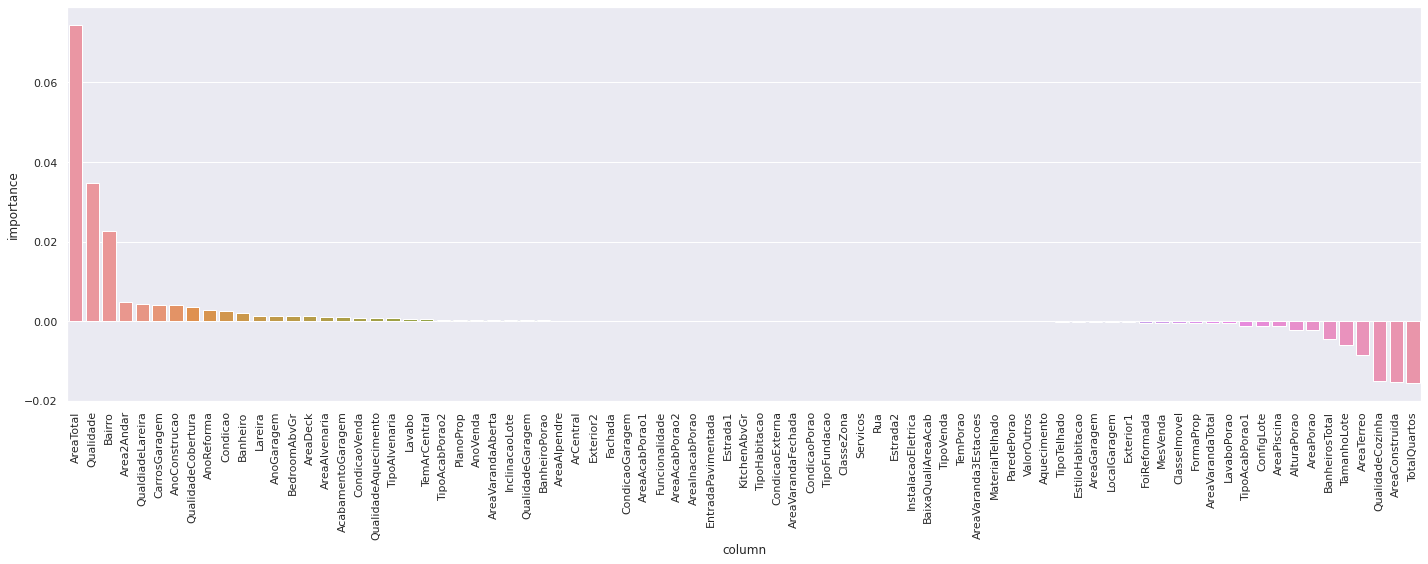

In [ ]:
importances = pd.DataFrame({'column' : X_val.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
# Getting the top 25 best features
best_features = importances.head(25).column.tolist()
print(best_features)

['AreaTotal', 'Qualidade', 'Bairro', 'Area2Andar', 'QualdiadeLareira', 'CarrosGaragem', 'AnoConstrucao', 'QualidadeCobertura', 'AnoReforma', 'Condicao', 'Banheiro', 'Lareira', 'AnoGaragem', 'BedroomAbvGr', 'AreaDeck', 'AreaAlvenaria', 'AcabamentoGaragem', 'CondicaoVenda', 'QualidadeAquecimento', 'TipoAlvenaria', 'Lavabo', 'TemArCentral', 'TipoAcabPorao2', 'PlanoProp', 'AnoVenda']


### Retreinando o modelo apenas com as top 25 variáveis mais importantes

In [ ]:
# Fitting the final RandomForest model
rf_model = RandomForestRegressor(n_estimators=150, max_features=0.3, min_samples_leaf= 1, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Computing predictions
y_train_pred = rf_model.predict(X_train[best_features])
y_val_pred = rf_model.predict(X_val[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Computing the train, validation and test model performance metrics
train_report = metrics_report(y_train, y_train_pred, 'train')
val_report = metrics_report(y_val, y_val_pred, 'validation')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report, val_report[['validation']],  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(df)})')
print(baseline_report)
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 1460)
            metric  validation
0             RMSE    37293.08
1              MAE    16986.60
2              R^2        0.79
3             MAPE        0.10
4      Avg. target   179133.59
5  Avg. Prediction   181957.96

Final report (total features: 25)
            metric      train  validation       test
0             RMSE   10329.31    28623.54   31392.55
1              MAE    6397.16    16413.52   17990.85
2              R^2       0.98        0.88       0.84
3             MAPE       0.04        0.10       0.10
4      Avg. target  180696.36   179133.59  183758.01
5  Avg. Prediction  180396.70   180554.38  183371.01


Running permutation feature importance with the final model on the held-out testing set


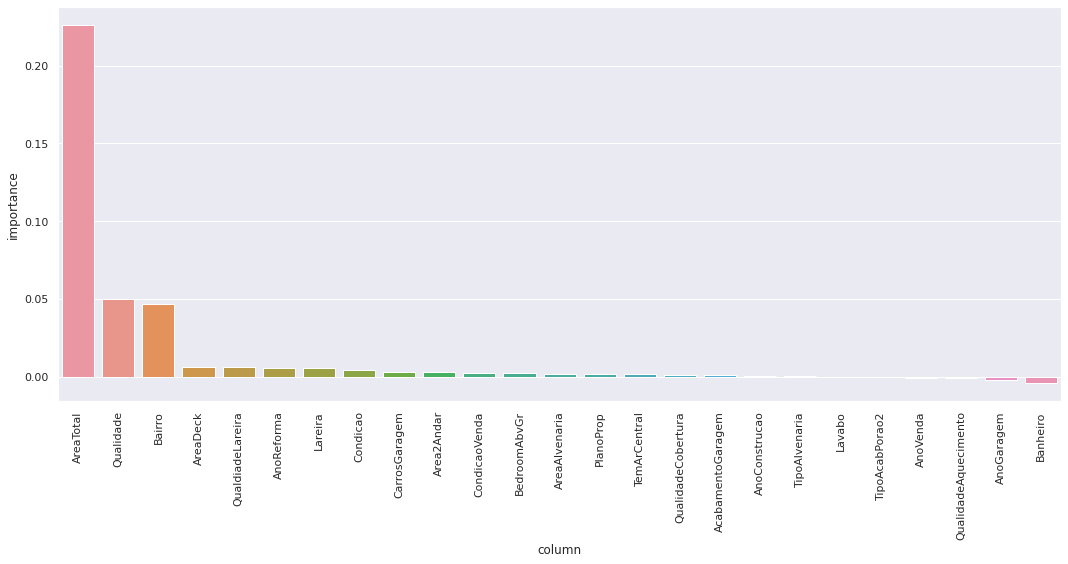

In [ ]:
# Computanto a importancia das features do modelo final no dataset de test (held-out testing set)

print('Running permutation feature importance with the final model on the held-out testing set')
permutation_result = permutation_importance(rf_model, X_test[best_features], y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test[best_features].columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()